In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import r2_score,mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from sklearn import linear_model as lm
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.interpolate import UnivariateSpline

data=pd.read_pickle('AQI-FE1-Binarized.pkl')
dx=data[[ 'Month', 'Quarter', 'Dayofweek', 'HourofDay',
       'DayofMonth', 'Dayoftheyear', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday','T']].copy(deep=True)
dx.sort_index(inplace=True)

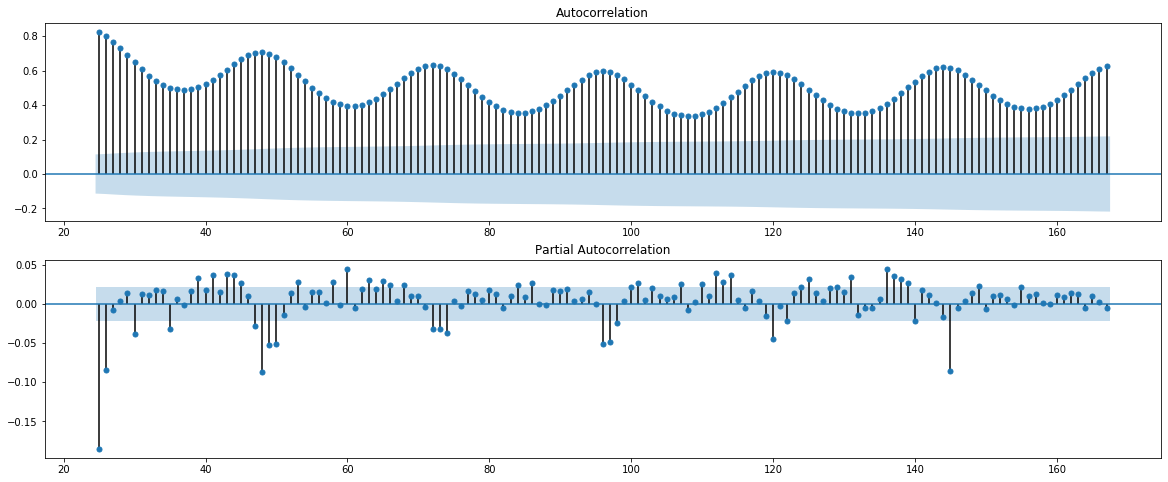

In [2]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=[20,8])
plt.subplot(211)
plot_acf(dx['T'].values, ax=plt.gca(),lags=range(25,168))
plt.subplot(212)
plot_pacf(dx['T'].values, ax=plt.gca(),lags=range(25,168))
plt.show()

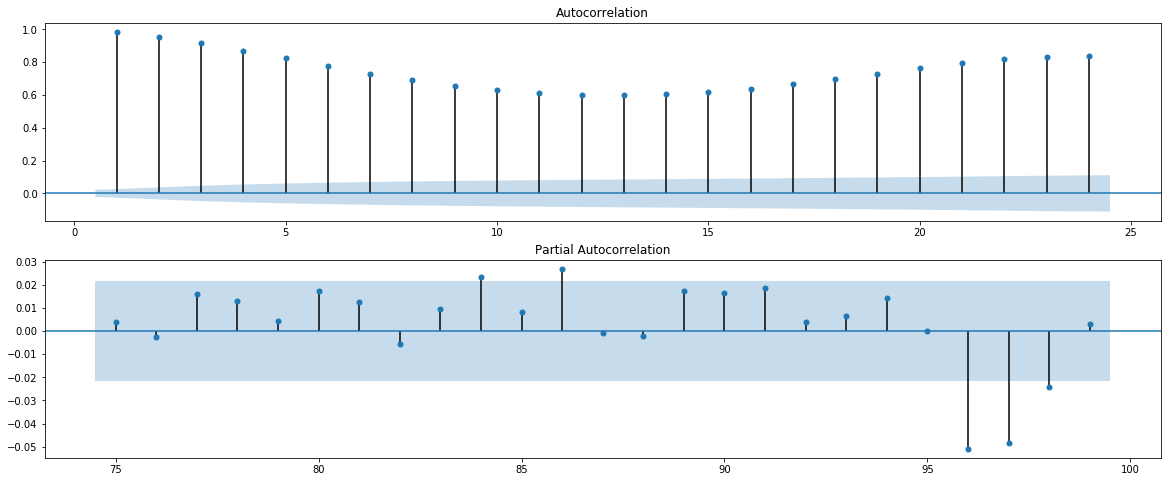

In [3]:
plt.figure(figsize=[20,8])
plt.subplot(211)
plot_acf(dx['T'].values, ax=plt.gca(),lags=range(1,25))
plt.subplot(212)
plot_pacf(dx['T'].values, ax=plt.gca(),lags=range(75,100))
plt.show()

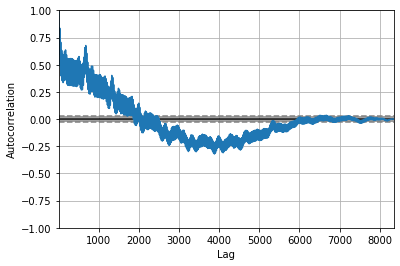

In [4]:

from pandas.plotting import autocorrelation_plot,lag_plot
autocorrelation_plot(dx['T'])

In [5]:
dx['shift-1']=dx['T'].loc[:'2005-3-1'].shift(periods=1)
dx['shift-2']=dx['T'].loc[:'2005-3-1'].shift(periods=2)
dx['shift-3']=dx['T'].loc[:'2005-3-1'].shift(periods=3)
dx['shift-9']=dx['T'].loc[:'2005-3-1'].shift(periods=9)
dx['shift-13']=dx['T'].loc[:'2005-3-1'].shift(periods=13)
dx['shift-14']=dx['T'].loc[:'2005-3-1'].shift(periods=14)
dx['shift-15']=dx['T'].loc[:'2005-3-1'].shift(periods=15)
dx['shift-16']=dx['T'].loc[:'2005-3-1'].shift(periods=16)
dx['shift-17']=dx['T'].loc[:'2005-3-1'].shift(periods=17)
dx['shift-24']=dx['T'].loc[:'2005-3-1'].shift(periods=24)
dx['shift-25']=dx['T'].loc[:'2005-3-1'].shift(periods=25)
dx['shift-26']=dx['T'].loc[:'2005-3-1'].shift(periods=26)
dx['shift-48']=dx['T'].loc[:'2005-3-1'].shift(periods=48)
#dx['shift-145']=dx['T'].loc[:'2005-3-1'].shift(periods=145)



In [6]:
train=dx.loc[:'2005-3-1'].copy(deep=True)
train.dropna(inplace=True)
test=dx.loc['2005-3-2':].copy(deep=True)

In [7]:
#attb=['rolling-72','rolling-48','rolling-24','rolling-12']
attb=[ 'HourofDay',
        'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday',
    'shift-1'
      ,'shift-2','shift-3','shift-9','shift-13','shift-14','shift-15',
      'shift-16','shift-17','shift-24','shift-25','shift-26','shift-48',
      #'shift-145'
     ]
RM = lm.LinearRegression()
RM.fit(train[attb],train['T'])
#RM.fit(train[attb].loc['2005-2-20':],train['T'].loc['2005-2-20':])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [8]:
test.index.size

615

In [9]:
window=train['T'].loc["2005-2-20":].values.tolist()
window[-12:]
dta_lst=[]
ctr=0
for x in test.index:
    lst=[#test['Month'].loc[x],
         #test['DayofMonth'].loc[x],
         test['HourofDay'].loc[x],test['Monday'].loc[x],
         test['Tuesday'].loc[x],test['Wednesday'].loc[x],test['Thursday'].loc[x],
         test['Friday'].loc[x],test['Saturday'].loc[x],test['Sunday'].loc[x],
        window[-1]
         ,window[-2],window[-3],window[-9],window[-13],window[-14],window[-15]
         ,window[-16],window[-17],window[-24],window[-25],window[-26],window[-48]#,window[-145]
        ]
    
    pred=RM.predict(np.asarray([lst]).reshape(1,-22))
    window.append(pred[0])
    lst.append(pred[0])
    dta_lst.append(lst)

#train['T'].loc["2005-2-27":]

In [10]:
collist=[ 'HourofDay',
        'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday',
    'shift-1',
         'shift-2','shift-3','shift-9','shift-13','shift-14','shift-15',
      'shift-16','shift-17','shift-24','shift-25','shift-26','shift-48',
      #'shift-145',
         'Prediction']
prediction=pd.DataFrame(dta_lst,columns=collist,dtype='float')
prediction.index=test.index

In [11]:
test['shift-1']=prediction['shift-1'].copy(deep=True)
test['shift-2']=prediction['shift-2'].copy(deep=True)
test['shift-3']=prediction['shift-3'].copy(deep=True)
test['Prediction']=prediction['Prediction'].copy(deep=True)

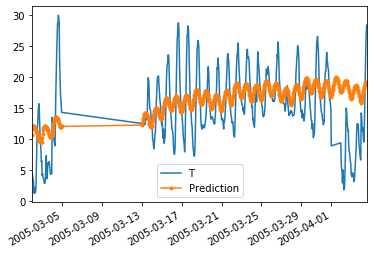

In [17]:
fig, ax = plt.subplots()
#finding trend using rolling window operation
test.plot(y='T',ax=ax)
test.plot(y='Prediction',ax=ax,style='.-')


In [13]:
mean_squared_error(test['T'].loc['2005-3-2':'2005-3-8'], test['Prediction'].loc['2005-3-2':'2005-3-8'])

57.3662464664949

In [16]:
r2_score(test['T'].loc['2005-3-2':'2005-3-8'], test['Prediction'].loc['2005-3-2':'2005-3-8'])

0.059828718370626977

In [ ]:
from fbprophet import Prophet


In [15]:
attb=[ 'HourofDay',
        'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday',
    'shift-1'
      ,'shift-2','shift-3','shift-9','shift-13','shift-14','shift-15',
      'shift-16','shift-17','shift-24','shift-25','shift-26','shift-48',
      'shift-145'
     ]
reg2 = RandomForestRegressor(random_state=1, n_estimators=25,max_depth=10,
                             min_samples_leaf=3,min_samples_split=2)
reg2.fit(train[attb].loc['2005-2-26':],train['T'].loc['2005-2-26':])
window=train['T'].values.tolist()
window[-12:]
dta_lst=[]
ctr=0
for x in test.index:
    lst=[#test['Month'].loc[x],
         #test['DayofMonth'].loc[x],
         test['HourofDay'].loc[x],test['Monday'].loc[x],
         test['Tuesday'].loc[x],test['Wednesday'].loc[x],test['Thursday'].loc[x],
         test['Friday'].loc[x],test['Saturday'].loc[x],test['Sunday'].loc[x],
        window[-1]
         ,window[-2],window[-3],window[-9],window[-13],window[-14],window[-15]
         ,window[-16],window[-17],window[-24],window[-25],window[-26],window[-48],window[-145]
        ]
    
    pred=reg2.predict(np.asarray([lst]).reshape(1,-22))
    window.append(pred[0])
    lst.append(pred[0])
    dta_lst.append(lst)

collist=[ 'HourofDay',
        'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday',
    'shift-1',
         'shift-2','shift-3','shift-9','shift-13','shift-14','shift-15',
      'shift-16','shift-17','shift-24','shift-25','shift-26','shift-48',
      'shift-145',
         'Prediction']
prediction=pd.DataFrame(dta_lst,columns=collist,dtype='float')
prediction.index=test.index
test['Prediction-RF']=prediction['Prediction'].copy(deep=True)

fig, ax = plt.subplots()
#finding trend using rolling window operation
test.plot(y='T',ax=ax)
test.plot(y='Prediction-RF',ax=ax)

KeyError: "['shift-145'] not in index"

In [ ]:
pred = RM.predict(test[attb])
pred=pd.DataFrame(pred,columns=['Prediction'])
pred.index=test.index
test1=pd.concat([test,pred],axis=1)

In [ ]:
fig, ax = plt.subplots()
#finding trend using rolling window operation
dx.plot(y='T',ax=ax)
test1.plot(y='Prediction',ax=ax)
dx.plot(y='T')

In [ ]:
mean_squared_error(test1['T'], test1['Prediction'])

In [ ]:
r2_score(test1['T'], test1['Prediction'])

In [ ]:
reg2 = RandomForestRegressor(random_state=1, n_estimators=100,max_depth=30,min_samples_leaf=3,min_samples_split=5)
reg2.fit(train[attb],train['T'])
pred = reg2.predict(test[attb])
pred=pd.DataFrame(pred,columns=['Prediction'])
pred.index=test.index
test1=pd.concat([test,pred],axis=1)
fig, ax = plt.subplots()
#finding trend using rolling window operation
dx.plot(y='T',ax=ax)
test1.plot(y='Prediction',ax=ax)
dx.plot(y='T')

In [ ]:
mean_squared_error(test1['T'], test1['Prediction'])


In [ ]:
r2_score(test1['T'], test1['Prediction'])